In [1]:
# Load packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from FDApy import DenseFunctionalData, MultivariateFunctionalData
from FDApy.representation.functional_data import BasisFunctionalData
from FDApy.representation import DenseArgvals, DenseValues
from FDApy.preprocessing import MFPCA
from FDApy.visualization import plot, plot_multivariate

from nba import NbaScraper, ShotCharts

plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r'\usepackage{amsfonts}'
})

In [2]:
# Load data
with open('./data/players_shots_density.pickle', 'rb') as f:
    players_shots_density = pickle.load(f)
with open('./data/players_shots_density_made.pickle', 'rb') as f:
    players_shots_density_made = pickle.load(f)
with open('./data/player_position.pickle', 'rb') as f:
    players_position = pickle.load(f)
    
# Load MFPCA results
with open('./data/MFPCA_PSplines.pickle', 'rb') as f:
    mfpca = pickle.load(f)
with open('./data/scores_PSplines.pickle', 'rb') as f:
    scores = pickle.load(f)
with open('./data/MFPCA_PSplines_reconstruction.pickle', 'rb') as f:
    fdata_reconstruction = pickle.load(f)

In [3]:
# Get parameters
n_obs = 5  # mfpca.eigenfunctions.n_obs
n_comp = mfpca.eigenfunctions.n_functional

In [4]:
# Sort by ID
# players_shots_density = players_shots_density.sort_values(by='PLAYER_ID')
# players_shots_density_made = players_shots_density_made.sort_values(by='PLAYER_ID')
# players_position = players_position.sort_values(by='PLAYER_ID')

In [5]:
# Reindex everything
# players_shots_density = players_shots_density.reset_index().drop(columns=['index'])
# players_shots_density_made = players_shots_density_made.reset_index().drop(columns=['index'])
# players_position = players_position.reset_index().drop(columns=['index'])

In [6]:
# Reshape scores
scores = pd.DataFrame(scores)
scores.insert(loc=0, column='PLAYER_ID', value=players_shots_density.PLAYER_ID.values)
scores.insert(loc=0, column='PLAYER_NAME', value=players_shots_density.PLAYER_NAME.values)
scores = scores.join(players_position.set_index('PLAYER_ID'), how='left', on='PLAYER_ID', rsuffix='_')

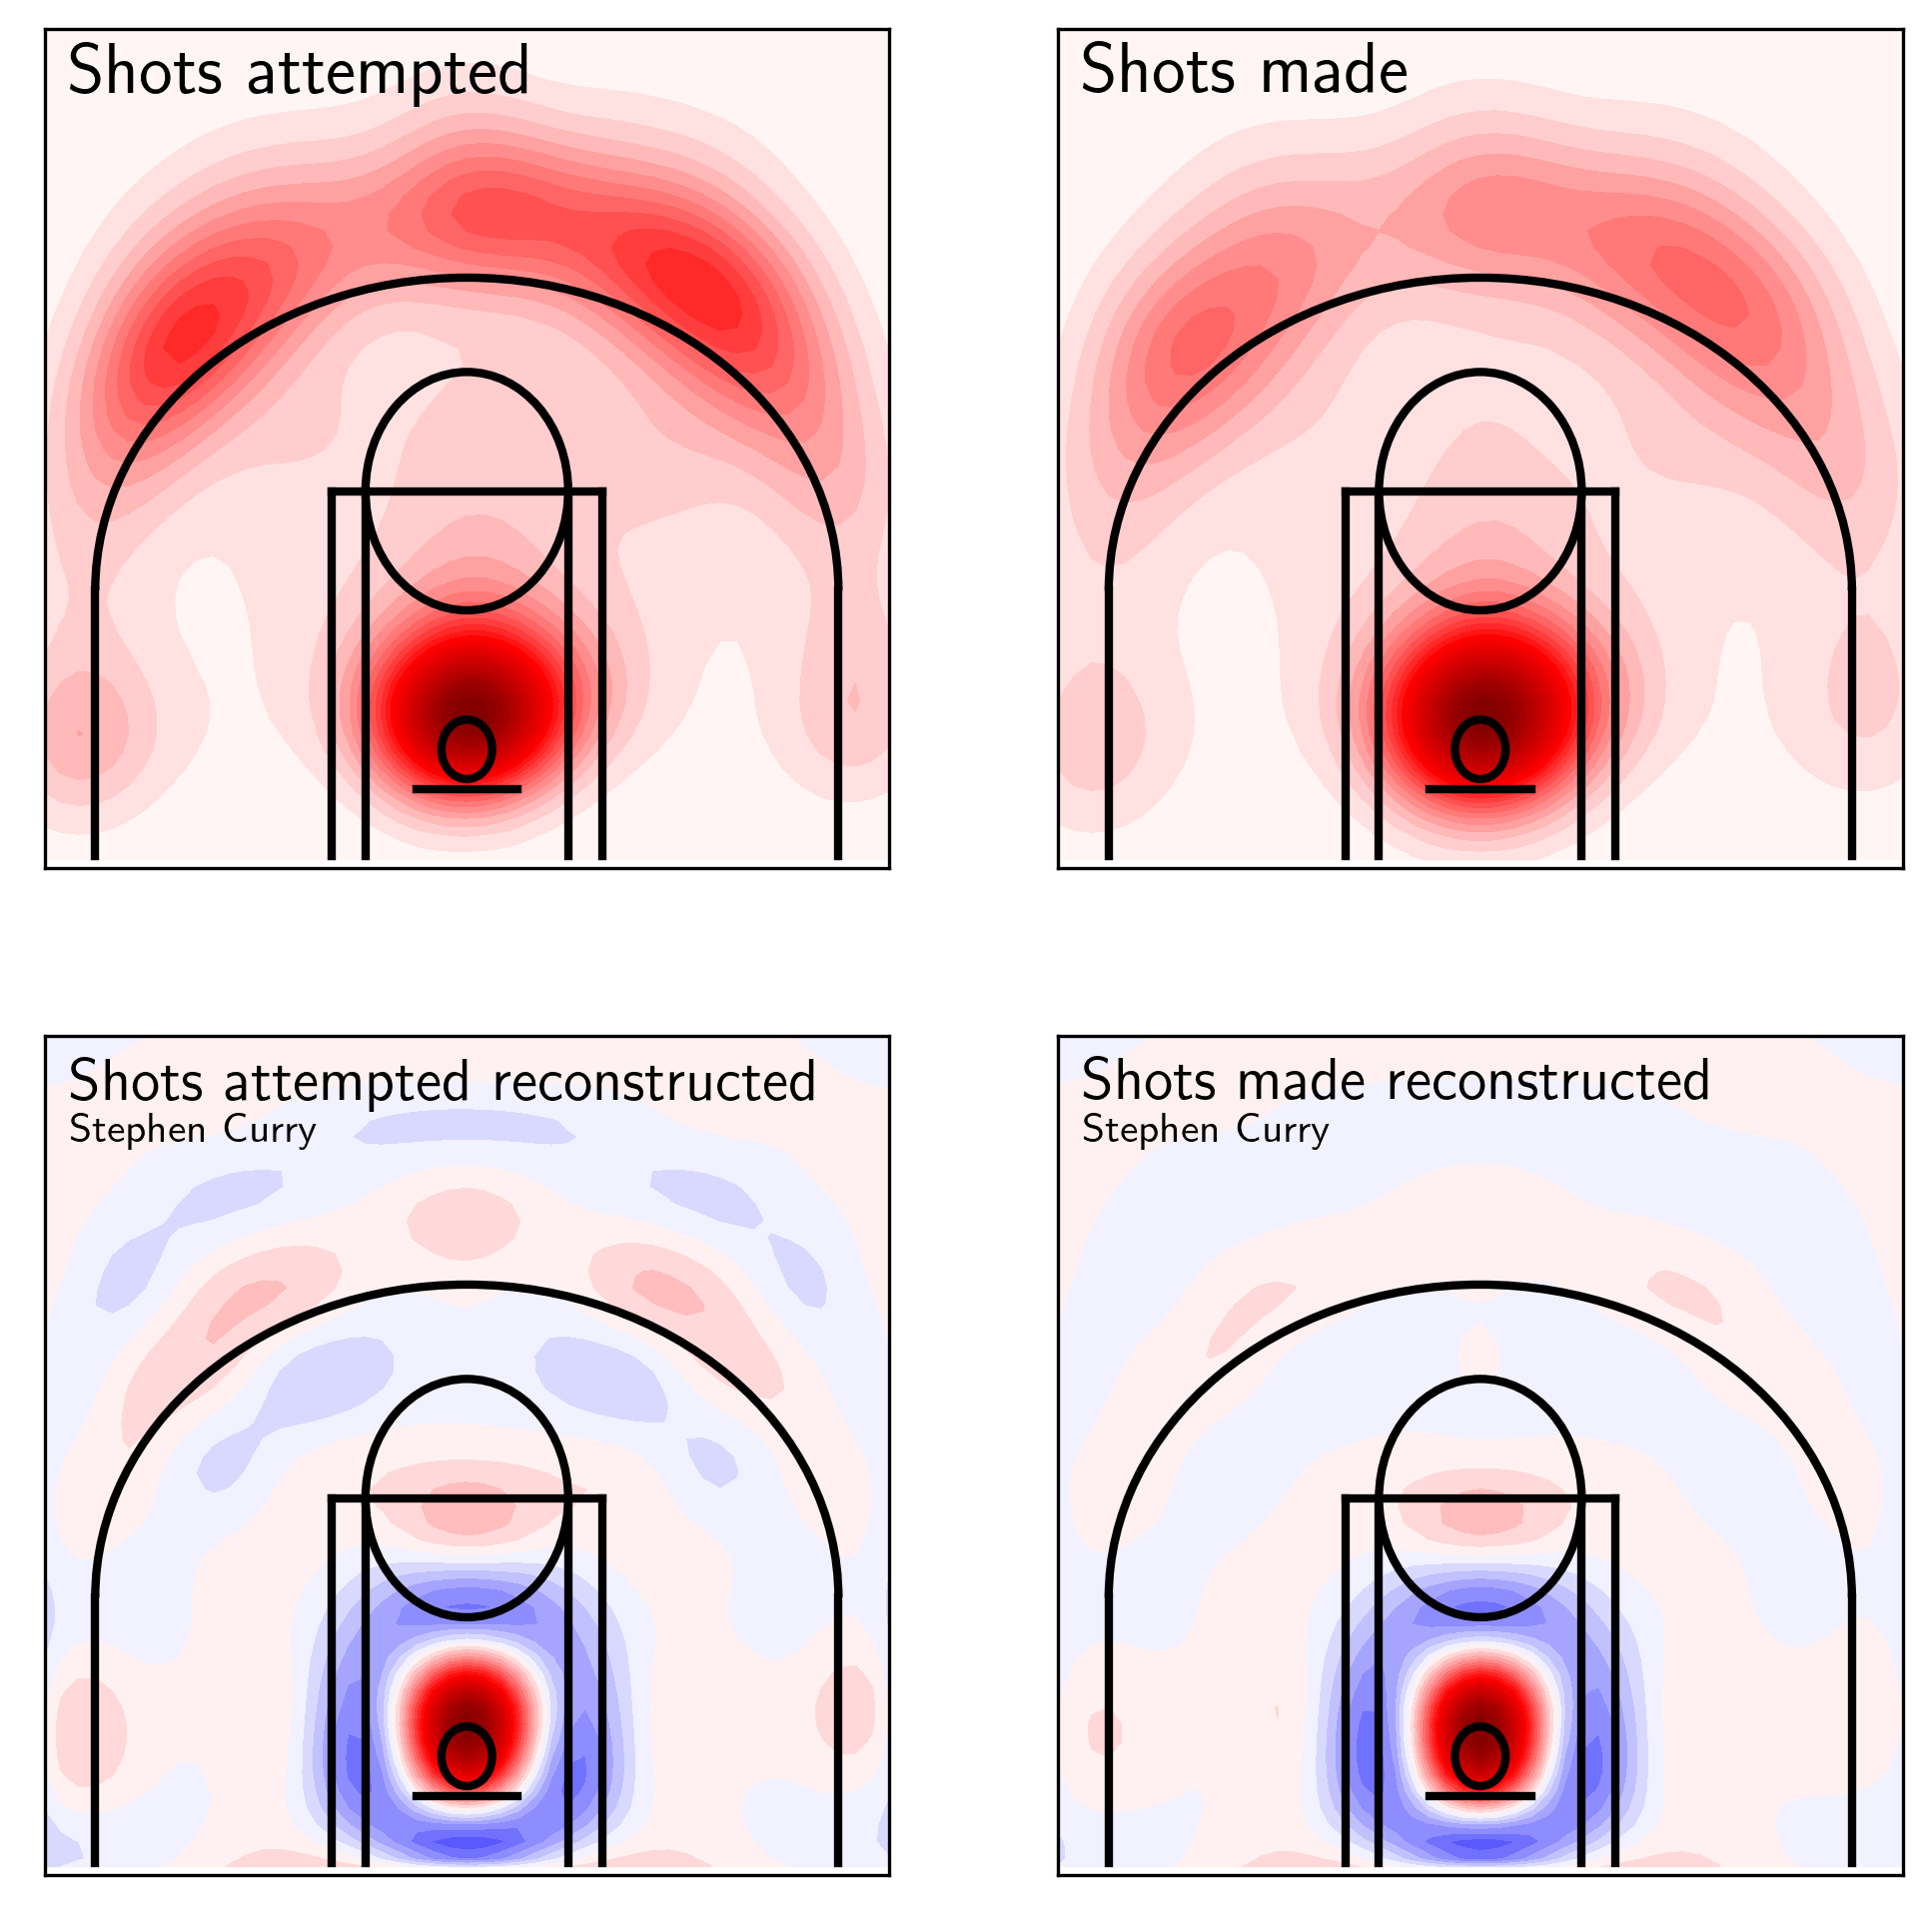

In [7]:
name = 'Stephen Curry'
fig, ax = plt.subplots(
    2, 2,
    figsize=(8, 8),
    facecolor='white',
    edgecolor='black',
    dpi=300
)
ax[0, 0] = ShotCharts.shots_chart(
    ax[0, 0], players_shots_density, name, 'Shots attempted', False
)
ax[0, 1] = ShotCharts.shots_chart(
    ax[0, 1], players_shots_density_made, name, 'Shots made', False
)

ax[1, 0] = ShotCharts.shots_chart_reconstruction(
    ax[1, 0], players_shots_density, fdata_reconstruction.data[0], name, 'Shots attempted reconstructed', False
)
ax[1, 1] = ShotCharts.shots_chart_reconstruction(
    ax[1, 1], players_shots_density_made, fdata_reconstruction.data[1], name, 'Shots made reconstructed', False
)

#plt.savefig('./figures/curry_reconstruction.eps', transparent=True, format='eps')
#plt.show()

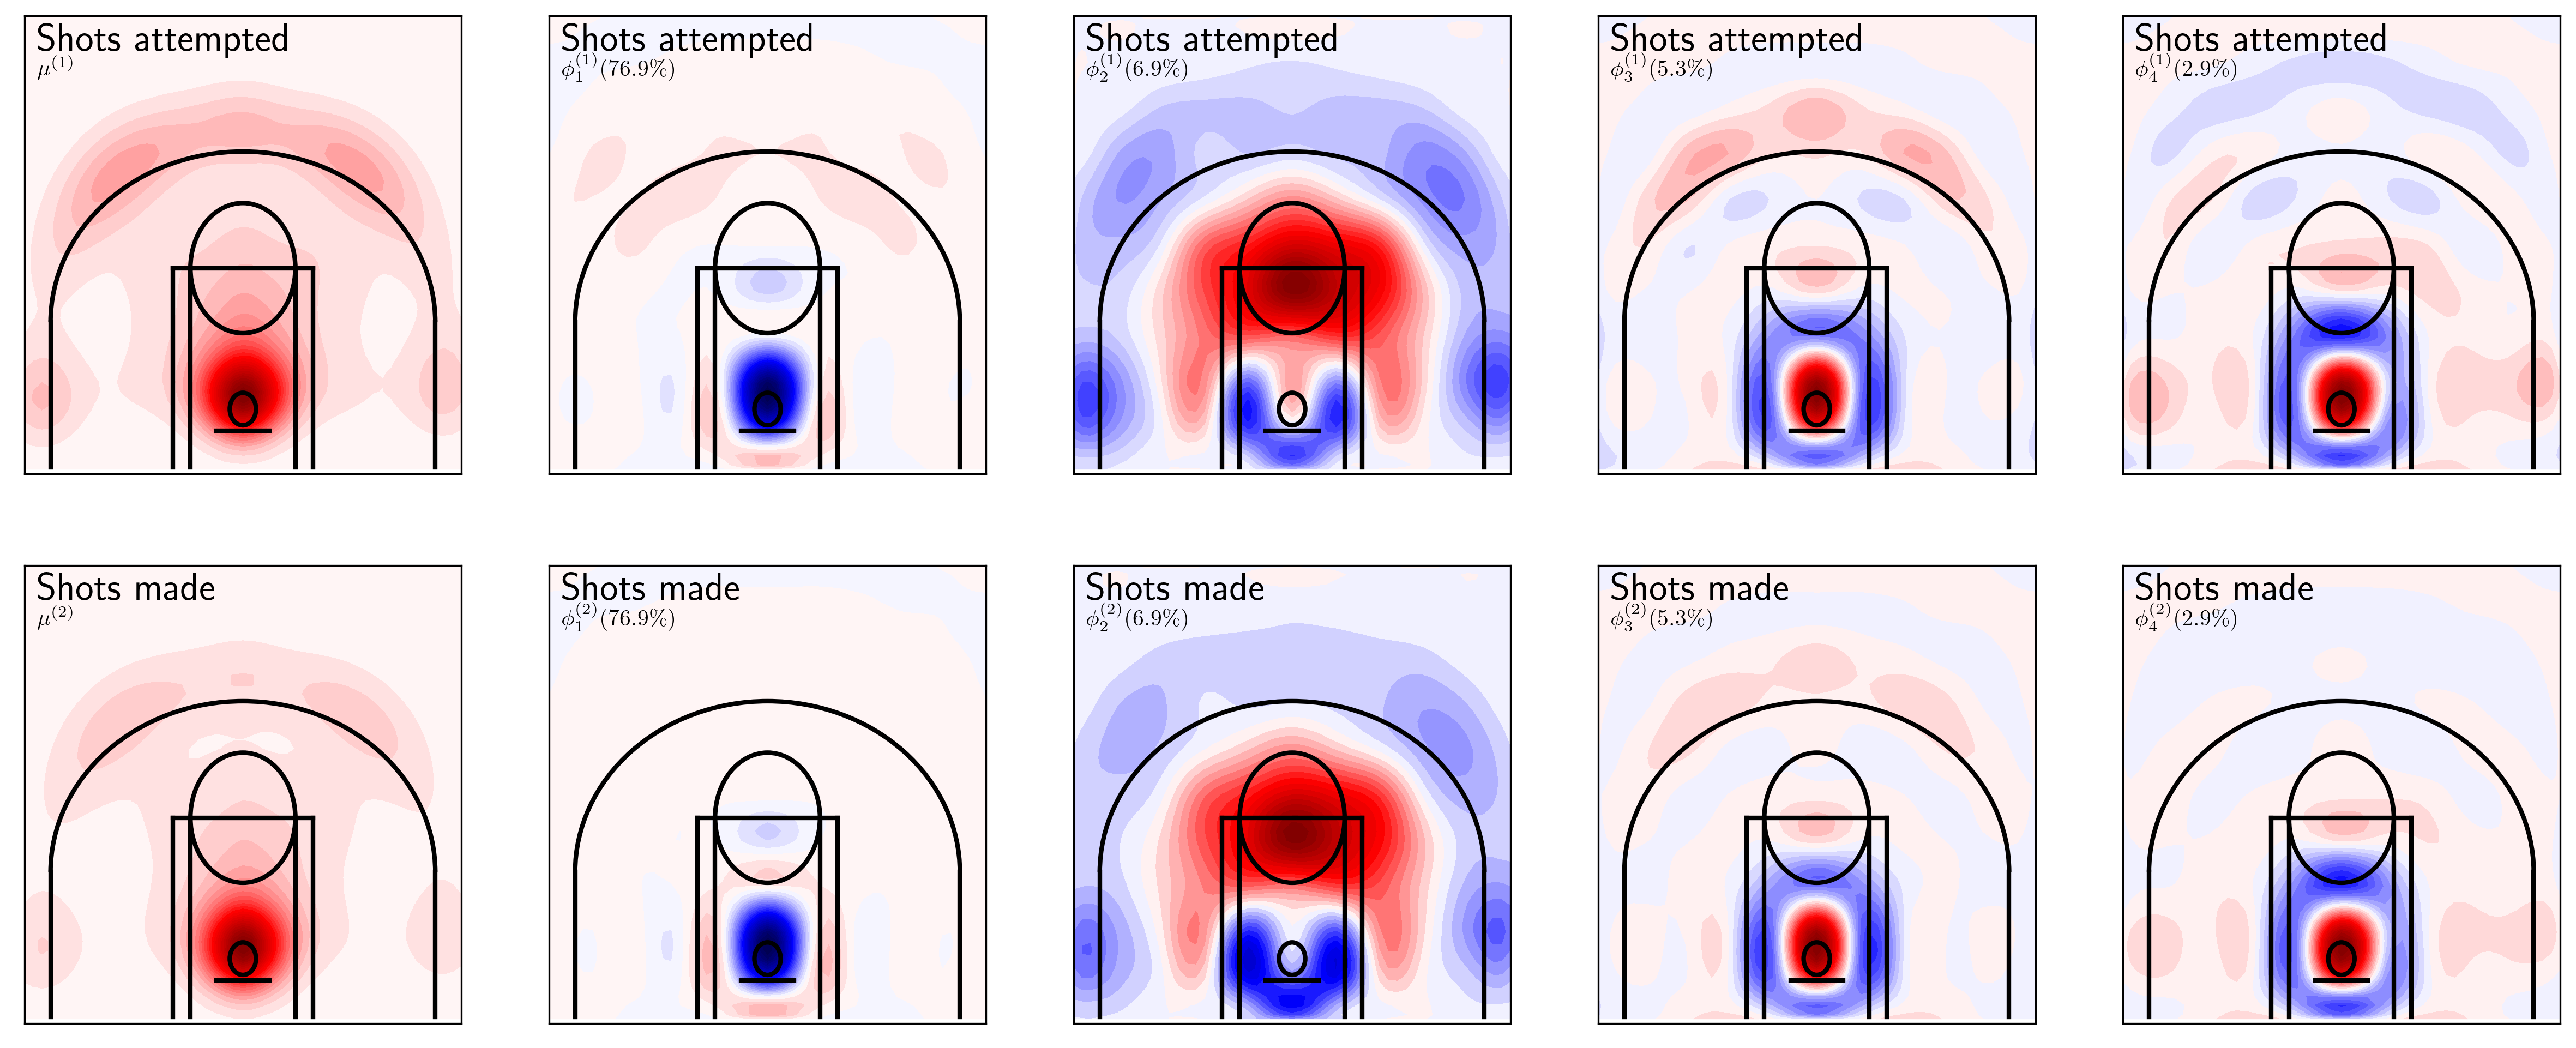

In [8]:
fig, axes = plt.subplots(
    n_comp, 4 + 1,
    figsize=(4 * (4 + 1), 4 * n_comp),
    facecolor='white',
    edgecolor='black',
    dpi=300
)

axes[0, 0] = ShotCharts.mean_chart(
    axes[0, 0], mfpca, 0, 'Shots attempted'
)
axes[1, 0] = ShotCharts.mean_chart(
    axes[1, 0], mfpca, 1, 'Shots made',
)

for idx_o in np.arange(4):
    for idx_c in np.arange(n_comp):
        title = 'Shots attempted' if idx_c == 0 else 'Shots made'
        axes[idx_c, idx_o + 1] = ShotCharts.components_chart(
            axes[idx_c, idx_o + 1], mfpca, idx_o, idx_c, title)
#plt.savefig('./figures/eigenfunctions.eps', transparent=True, format='eps')
plt.show()

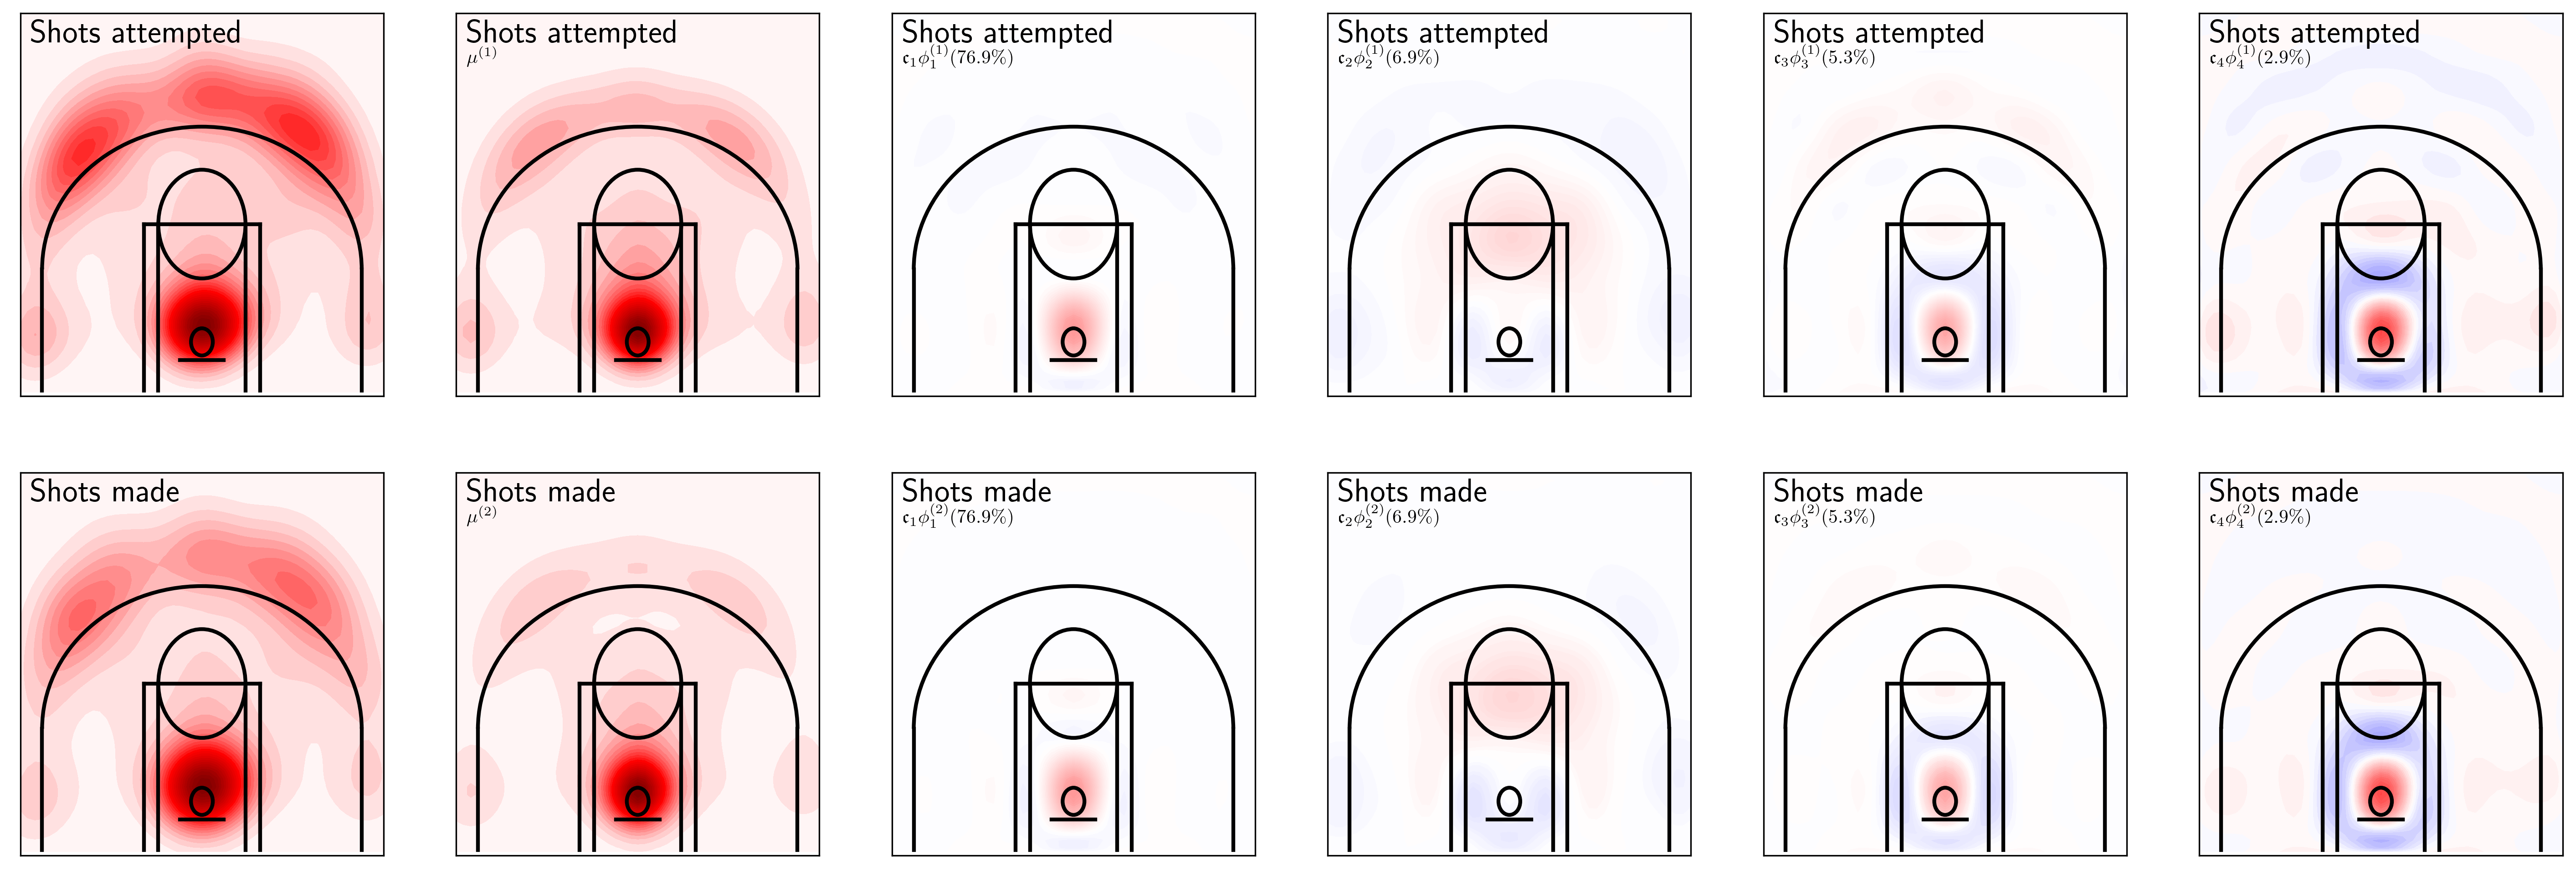

In [9]:
name = 'Stephen Curry'
fig, axes = plt.subplots(
    n_comp, 4 + 2,
    figsize=(4 * (4 + 2), 4 * n_comp),
    facecolor='white',
    edgecolor='black',
    dpi=300
)

axes[0, 0] = ShotCharts.shots_chart(
    axes[0, 0], players_shots_density,
    name, 'Shots attempted', add_headshot=False
)
axes[1, 0] = ShotCharts.shots_chart(
    axes[1, 0], players_shots_density_made,
    name, 'Shots made', add_headshot=False
)

axes[0, 1] = ShotCharts.mean_chart(
    axes[0, 1], mfpca, 0, 'Shots attempted'
)
axes[1, 1] = ShotCharts.mean_chart(
    axes[1, 1], mfpca, 1, 'Shots made',
)

for idx_o in np.arange(4):
    for idx_c in np.arange(n_comp):
        if isinstance(mfpca.eigenfunctions.data[idx_c], BasisFunctionalData):
            eigenfunctions = mfpca.eigenfunctions.data[idx_c].to_grid()
        else:
            eigenfunctions = mfpca.eigenfunctions.data[idx_c]
        title = 'Shots attempted' if idx_c == 0 else 'Shots made'
        maxi = np.max(np.abs(
            np.einsum('i, jk -> ijk', scores[idx_o].values, eigenfunctions[idx_o].values.squeeze())
        ))
        axes[idx_c, idx_o + 2] = ShotCharts.shots_decomposition_chart(
            axes[idx_c, idx_o + 2], mfpca, scores,
            idx_o, idx_c, name, title, maxi
        )
#plt.savefig('./figures/curry_decomposition.eps', transparent=True, format='eps')
plt.show()